In [ ]:
# Connect colab with google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
 # Importing required libraries

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import pickle

from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Loading Dataset

dataset_column_names  = ["sentiment", "ids", "date", "flag", "user", "text"]
dataset = pd.read_csv("/content/drive/MyDrive/training.1600000.processed.noemoticon.csv",encoding="ISO-8859-1",names = dataset_column_names)
print(dataset.head())
print(dataset.columns)

# Eliminate unneccessary columns => required = sentiment,text
dataset = dataset[["sentiment","text"]]
print(dataset.head())
print(dataset.columns)

# replace sentiment value 4 -> 1
dataset["sentiment"] = dataset["sentiment"].replace(4,1)

#Converting to list
sentiment = list(dataset["sentiment"])
text = list(dataset["text"])
print("l",len(text))
print(len(sentiment))

   sentiment         ids                          date      flag  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
Index(['sentiment', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')
   sentiment                                               text
0          0  @swit

             text
sentiment        
0          800000
1          800000


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

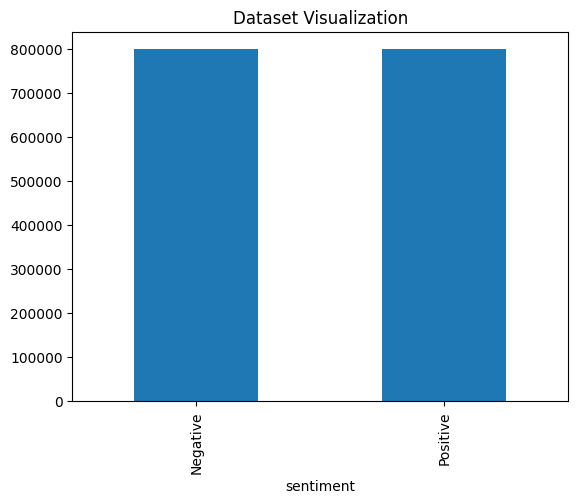

In [ ]:
print(dataset.groupby("sentiment").count())

# Visualizing Distribution of dataset
ax = dataset.groupby("sentiment").count().plot(kind = "bar", title = "Dataset Visualization", legend = False)
ax.set_xticklabels(["Negative","Positive"])

In [ ]:
# Data preprocessing

# Setting stop words
stop_words = set(stopwords.words("english"))
#print(stop_words)

# Pairing emojis with their meaning
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def preprocess(text):

  processed_text = list()

  # Creating instance of Lemmatizer
  lemma = WordNetLemmatizer()
  #print(lemma)


  # Defining regex patterns.
  url_pattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  user_pattern       = '@[^\s]+'
  alpha_pattern      = "[^a-zA-Z0-9]"
  sequence_pattern   = r"(.)\1\1+"
  seq_replace_pattern = r"\1\1"

  for tweet in text:

    # Covert tweets to lowercase
    tweet = tweet.lower()

    # Replace urls with "URL"
    tweet = re.sub(url_pattern,"URL",tweet)

    # Replace emojis
    for emoji in emojis:
      tweet = tweet.replace(emoji,"Emoji"+emojis[emoji])

    # Replace @username to "USER"
    tweet = re.sub(user_pattern,"USER",tweet)

    # Replace non-alphabetic characters
    tweet = re.sub(alpha_pattern," ",tweet)

    # Replace 3 or more consecutive letters by 2 letters
    tweet = re.sub(sequence_pattern,seq_replace_pattern,tweet)

    # Lemmatizing tweets and eliminating stop word
    tweet_words = ""
    for word in tweet.split():
      if word not in stop_words:
        if(len(word) > 1):
          #print("B lemma",word)
          word = lemma.lemmatize(word)
          #print("A lemma",word)
          tweet_words += (word+" ")

    processed_text.append(tweet_words)
  return processed_text

preprocessed_text = preprocess(text)
print(preprocessed_text)

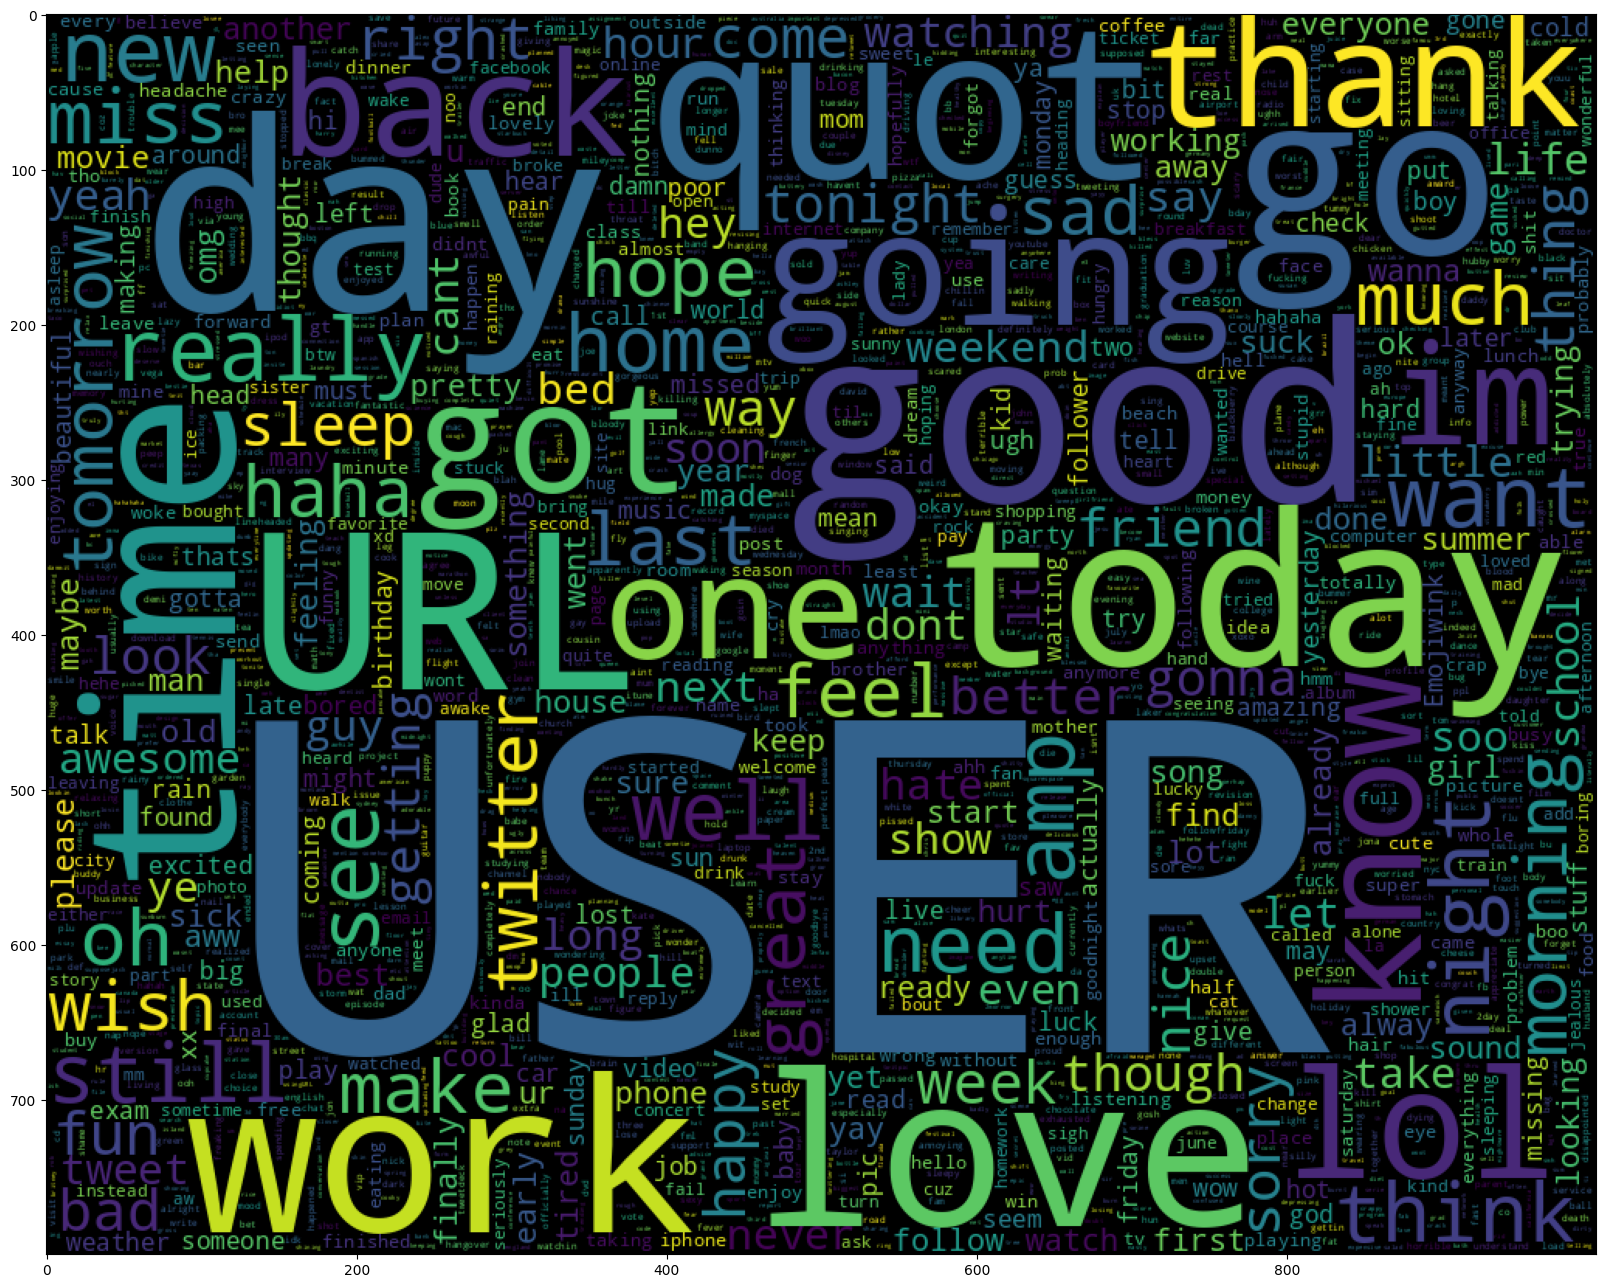

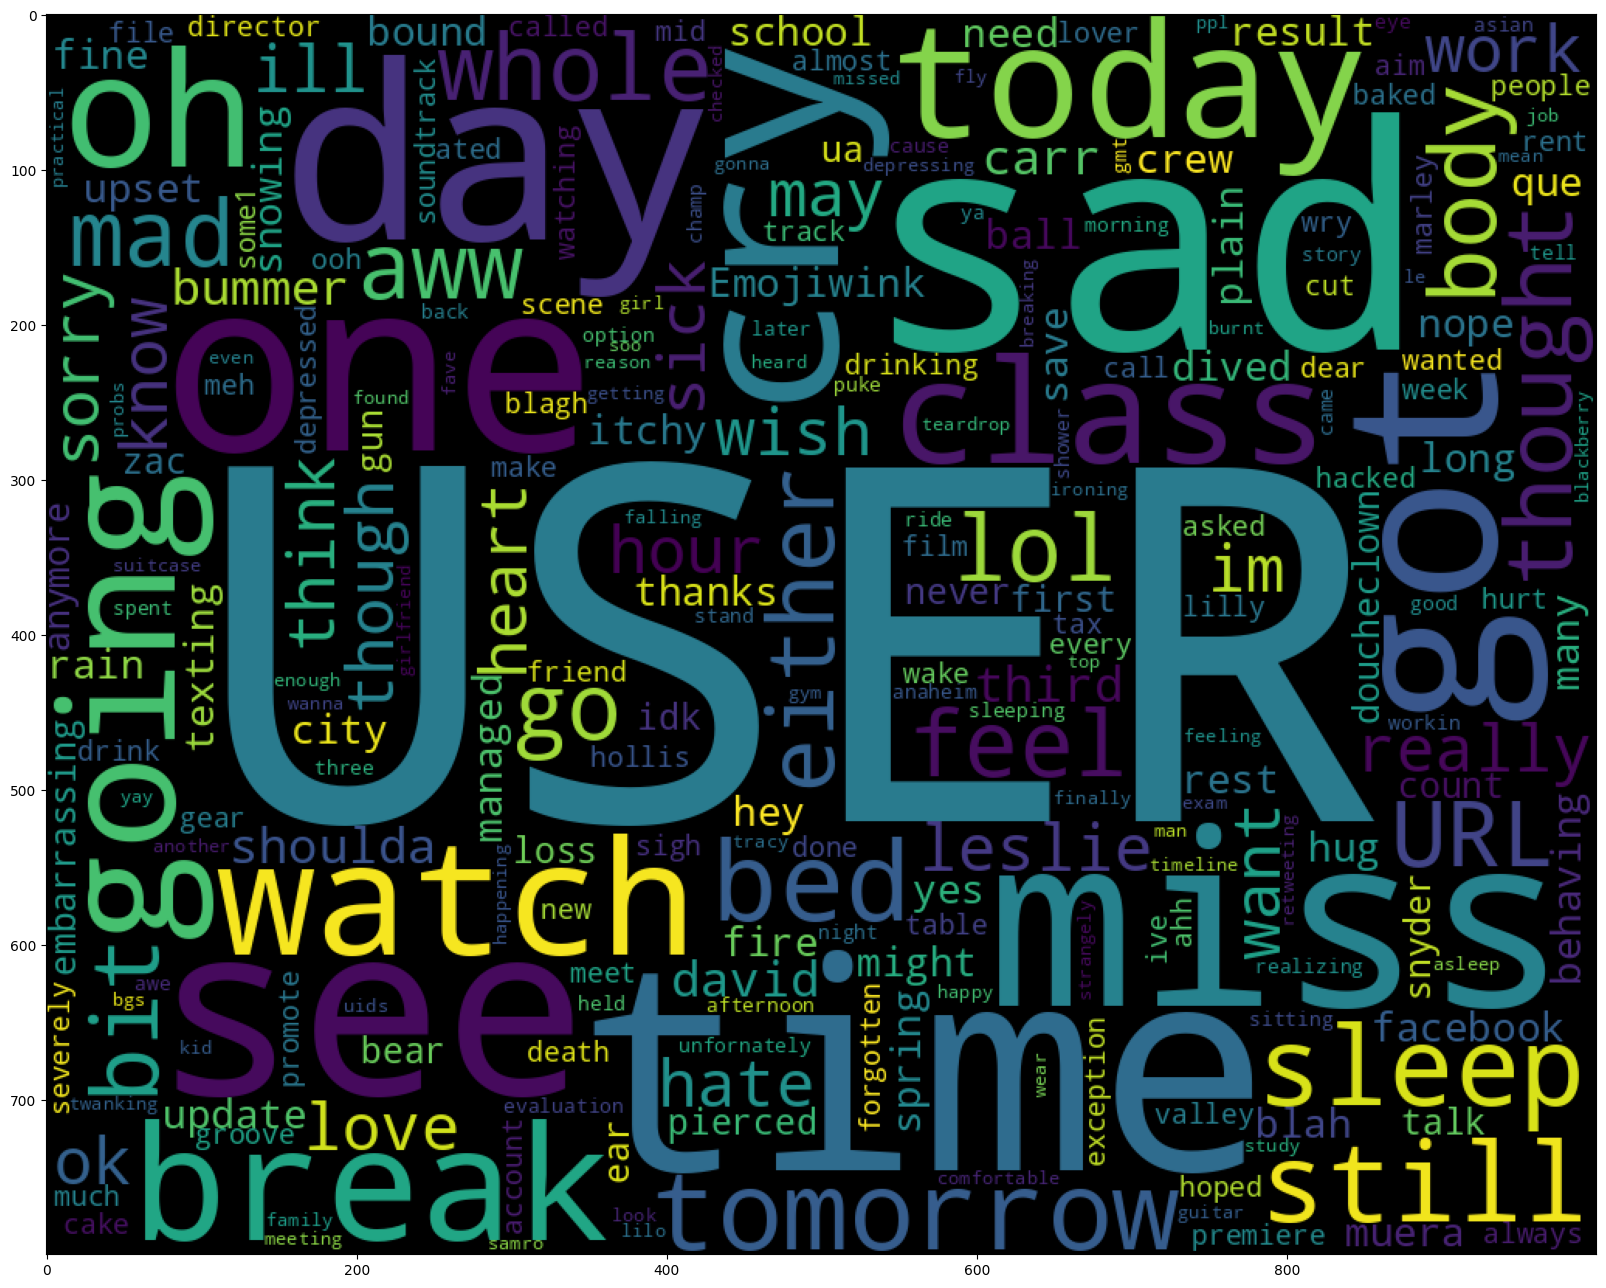

In [ ]:
# Wordcloud graphical representation of Data

# seperate positive and negative tweets
pos_tweet = preprocessed_text[50:]
neg_tweet = preprocessed_text[:50]

# Word cloud of positive tweets
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 10000, width = 1000, height = 800, collocations=False).generate(" ".join(pos_tweet))
plt.imshow(wc)

# Word cloud of negative tweets
plt.figure(figsize= (20,20))
wc = WordCloud(max_words = 10000, width = 1000, height = 800, collocations = False).generate(" ".join(neg_tweet))
plt.imshow(wc)

In [ ]:
# Model Training

# Data splitting
x_train,x_test,y_train,y_test = train_test_split(preprocessed_text,sentiment,test_size = 0.1)
print("Data splitted")

# TF-IDF feature extraction
tf_idf = TfidfVectorizer(ngram_range =(1,2), max_features = 500000)

# Training the TFf-IDF
tf_idf.fit(x_train)

# Displaying the feature words
print("No of Feature words : ",len(tf_idf.get_feature_names_out()))

# Transform text into tf-idf matrix
x_train = tf_idf.transform(x_train)
x_test = tf_idf.transform(x_test)

# print("X : ",x_train)
# print("Y : ",x_test)
print("Data Transformed")

file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(tf_idf, file)
file.close()

# Evaluation of Model
def model_evaluation(model):

  # Predict Test Data
  y_pred = model.predict(x_test)

  # Classification Report
  print("Classification Report : ",classification_report(y_test,y_pred))

# Train Model

lr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
bnb = BernoulliNB(alpha = 2)
svm = LinearSVC()

# lr.fit(x_train,y_train)
# model_evaluation(lr)

# bnb.fit(x_train,y_train)
# model_evaluation(bnb)

# svm.fit(x_train,y_train)
# model_evaluation(svm)

# Setting estimators
estimators = [ ("LogisticRegression",lr),("BernoulliNB",bnb),("SVM",svm)]

# Voting Classifier
ensemble_model = VotingClassifier(estimators,voting="hard")

# file = open('LR.pickle','wb')
# pickle.dump(LRmodel, file)
# file.close()

ensemble_model.fit(x_train,y_train)
model_evaluation(ensemble_model)
file = open('ensemble-model.pickle','wb')
pickle.dump(ensemble_model, file)
file.close()

Data splitted
No of Feature words :  500000
Data Transformed
Classification Report :                precision    recall  f1-score   support

           0       0.80      0.78      0.79     80135
           1       0.78      0.81      0.80     79865

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



In [ ]:
# Load saved mode
def load_model():

  # Load tf-idf transformed data
  file = open('/content/vectoriser-ngram-(1,2).pickle', 'rb')
  vectoriser = pickle.load(file)
  file.close()

  # Load Model
  file = open('/content/ensemble-model.pickle', 'rb')
  ensemble_model = pickle.load(file)
  file.close()

  return (vectoriser,ensemble_model)

# Predict
def predict_sentiment(vectoriser,model,tweet):

  # Process the tweet
  processed_tweet = vectoriser.transform(preprocess(tweet))

  # Predict sentiment
  sentiment = model.predict(processed_tweet)

  # Make a list of text with sentiment.
  data = []
  for text, pred in zip(tweet, sentiment):
    data.append((text,pred))

  #print(data)

  # Convert the list into a Pandas DataFrame.
  df = pd.DataFrame(data, columns = ['text','sentiment'])
  df = df.replace([0,1], ["Negative","Positive"])
  return df



# Main
if __name__ == "__main__":
  text = ["I hate twitter",
            "May the Force be with you.",
            "Mr. Stark, I don't feel so good",
            "I am fine ",
          "Feeling lonely",
          "Hello Everyone",
          "He's a corrupted politician",
        ]

  # Load model
  vectoriser,ensemble_model = load_model()

  # Predict
  res = predict_sentiment(vectoriser,ensemble_model,text)
  print(res)

                              text sentiment
0                   I hate twitter  Negative
1       May the Force be with you.  Positive
2  Mr. Stark, I don't feel so good  Positive
3                       I am fine   Positive
4                   Feeling lonely  Negative
5                   Hello Everyone  Positive
6      He's a corrupted politician  Negative
